In [1]:
!make -C .. regression_df

make: Entering directory '/home/martibosch/data-science/lausanne-heat-islands'
make: Nothing to be done for 'regression_df'.
make: Leaving directory '/home/martibosch/data-science/lausanne-heat-islands'


In [2]:
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from sklearn import (ensemble, inspection, linear_model, metrics,
                     model_selection, svm)
from sklearn import utils as sk_utils

from lausanne_heat_islands import utils

In [3]:
regression_df_filepath = '../data/interim/regression/regression-df.csv'

In [4]:
regression_df = pd.read_csv(regression_df_filepath, index_col=[0, 1])

In [5]:
def make_dataset(regression_df,
                 features=None,
                 target='tair_station',
                 shuffle=True):
    y = regression_df[target]
    if features is None:
        X = regression_df.drop(target, axis=1)
    else:
        X = regression_df[list(features)]

    if shuffle:
        X, y = sk_utils.shuffle(X, y)

    return X, y

In [6]:
regression_df.head()

lst_0    ndwi_0    lst_200  ndwi_200  \
2018-05-25 BOURG-EN-LAVAUX  26.014134 -0.334515  26.754689 -0.266422   
           BOVDCH           21.650461 -0.456614  21.830704 -0.392005   
           BOVDMR           26.395785 -0.229706  26.079124 -0.269882   
           BOVDSO           21.088022 -0.465147  21.477795 -0.417006   
           MARCELIN         24.975926 -0.355455  25.100744 -0.343064   

                              lst_400  ndwi_400    lst_600  ndwi_600  \
2018-05-25 BOURG-EN-LAVAUX  26.528556 -0.275616  26.043737 -0.260330   
           BOVDCH           22.426036 -0.401703  22.464239 -0.406227   
           BOVDMR           25.949049 -0.262776  25.356981 -0.217986   
           BOVDSO           22.195320 -0.388652  22.970605 -0.376730   
           MARCELIN         24.344891 -0.371353  24.286819 -0.371502   

                              lst_800  ndwi_800  elev  tair_station  
2018-05-25 BOURG-EN-LAVAUX  25.255805 -0.219232   519          21.1  
           BOVDCH           22.308259 -0.396235   680          17.3  
           BOVDMR           24.551374 -0.167194   380          21.2  
           BOVDSO           23.260748 -0.365749   500          19.8  
           MARCELIN         24.394364 -0.367017   436          18.5

After dropping the missing observations, the total number of samples is:

In [7]:
len(regression_df)

88

## Model performance

In [8]:
target = 'tair_station'

model_dict = {
    'lr': linear_model.LinearRegression,
    'svm': svm.SVR,    
    'rf': ensemble.RandomForestRegressor
}

In [9]:
X, y = make_dataset(regression_df, target=target)

model_perf_df = pd.DataFrame(columns=utils.METRIC_COLUMNS)
for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)
    y_pred = regr.predict(X)
    model_perf_df.loc[model.__name__] = utils.compute_model_perf(y, y_pred)

model_perf_df.style.set_caption('Table 1. Model performance with all samples')

,R^2,MAE,RMSE
LinearRegression,0.831891,1.197609,1.508089
SVR,0.014353,2.670680,3.651673
RandomForestRegressor,0.959696,0.580098,0.738427


If all the samples are considered, the random forest regressor achieves the best fit with a coefficient of determination of $R^2 = 0.960$, followed by the $R^2 = 0.832$ achieved by the ordinary linear regression.

### Cross validation

In [10]:
num_repetitions = 20
num_folds = 3

In [11]:
accuracy_df = pd.DataFrame(columns=model_dict.keys(),
                           index=range(num_repetitions))

for i in range(num_repetitions):
    X, y = make_dataset(regression_df, target=target)

    for model_label in model_dict:
        accuracy_df.loc[(i, model_label)] = model_selection.cross_val_score(
            model_dict[model_label](), X, y, cv=num_folds).mean()

# output a Table with nicer row/column labels
pd.DataFrame({
    'Cross validation R^2': accuracy_df.mean()
}).rename(index=lambda model_label: model_dict[model_label].__name__
          ).style.set_caption('Table 2. Cross validation scores')

,Cross validation R^2
LinearRegression,0.733352
SVR,-0.052696
RandomForestRegressor,0.658037


The cross validation suggests that the linear regression is more robust to missing data and also less likely to over-fit the observations than the random forest regressor.

## Feature importance

In [12]:
X, y = make_dataset(regression_df, target=target)

for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)

    importance_df = pd.DataFrame(
        inspection.permutation_importance(regr, X, y),
        index=regression_df.drop(target, axis=1).columns,
        columns=[f'importances_{param}' for param in ('mean', 'std')])
    print(model)
    print(
        importance_df.sort_values(by='importances_mean',
                                  ascending=False).head(10))
    print()

<class 'sklearn.linear_model._base.LinearRegression'>
          importances_mean  importances_std
ndwi_600         33.640700         2.362501
ndwi_400         19.532847         1.299918
ndwi_800          9.248844         1.082143
lst_400           6.955351         0.685711
lst_800           5.273210         0.393643
lst_600           2.000661         0.129117
ndwi_200          0.936471         0.080744
lst_0             0.532823         0.035535
lst_200           0.207912         0.043040
ndwi_0            0.086435         0.015615

<class 'sklearn.svm._classes.SVR'>
          importances_mean  importances_std
elev          7.243788e-02     4.198484e-02
lst_0         2.443178e-03     2.026184e-04
lst_200       2.309516e-03     1.966242e-04
lst_400       2.091987e-03     1.924334e-04
lst_600       1.963785e-03     1.801579e-04
lst_800       1.931546e-03     1.740002e-04
ndwi_0        3.660056e-07     1.337043e-07
ndwi_200      2.405239e-07     4.852929e-08
ndwi_400      2.250974e-07    

The feature importances change dramatically according to the regression model.

In the case of linear regression, the feature importances can be futher assessed by a F-test of significance:

In [13]:
est = sm.OLS(y, sm.add_constant(X))
est.fit().summary(title='Table 3. OLS regression results')

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Table 3. OLS regression results                        
==============================================================================
Dep. Variable:           tair_station   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     34.19
Date:                Fri, 15 May 2020   Prob (F-statistic):           5.61e-25
Time:                        08:05:12   Log-Likelihood:                -161.02
No. Observations:                  88   AIC:                             346.0
Df Residuals:                      76   BIC:                             375.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1760      3.369      0.349      0.728      -5.534       7.886
lst_0          0.4944      0.584      0.846      0.400      -0.669       1.658
ndwi_0        -6.1852      5.127     -1.206      0.231     -16.396       4.026
lst_200       -0.3267      0.885     -0.369      0.713      -2.089       1.435
ndwi_200     -28.5531     15.581     -1.833      0.071     -59.585       2.479
lst_400       -1.9332      1.765     -1.095      0.277      -5.449       1.583
ndwi_400     124.2456     46.749      2.658      0.010      31.138     217.353
lst_600        1.0526      2.963      0.355      0.723      -4.849       6.955
ndwi_600    -156.7220     55.931     -2.802      0.006    -268.119     -45.325
lst_800        1.7306      1.685      1.027      0.308      -1.626       5.087
ndwi_800      85.4412     22.732      3.759      0.000      40.167     130.715
elev          -0.0026      0.003     -0.810      0.420      -0.009       0.004
==============================================================================
Omnibus:                        3.766   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                3.337
Skew:                           0.475   Prob(JB):                        0.189
Kurtosis:                       3.086   Cond. No.                     2.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With a significance level of $p=0.05$, the results of the F-test suggest that the significant variables for the linear regression are the NDWI when spatially averaged over a 800m, 600m and 400m radius (in decreasing order of significance). The following most significant variable is the NDWI spatially averaged over a 200m radius ($p=0.071$) and without spatial averaging ($p=0.231$), and the LST spatially averaged over a 400m radius ($p=0.277$). With a $p=0.420$, the does not appear to be significant in this particular regression.

## Prediction with the chosen model

In [14]:
X, y = make_dataset(regression_df, shuffle=False)

# regr = ensemble.RandomForestRegressor().fit(X, y)
regr = linear_model.LinearRegression().fit(X, y)

y_pred = regr.predict(X)

## Unraveling the error patterns

In [15]:
comparison_df = regression_df.copy()

comparison_df['obs'] = y
comparison_df['pred'] = y_pred
comparison_df['err'] = y_pred - y
# comparison_df['sq_err'] = comparison_df['err']**2

comparison_df['date'] = pd.to_datetime(comparison_df.index.get_level_values(0))
comparison_df['station'] = comparison_df.index.get_level_values(1)

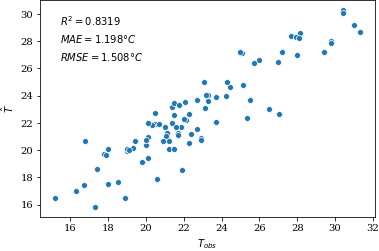

In [16]:
fig = utils.plot_pred_obs(comparison_df)
fig.savefig('../reports/figures/spatial-regression-pred-obs.pdf')

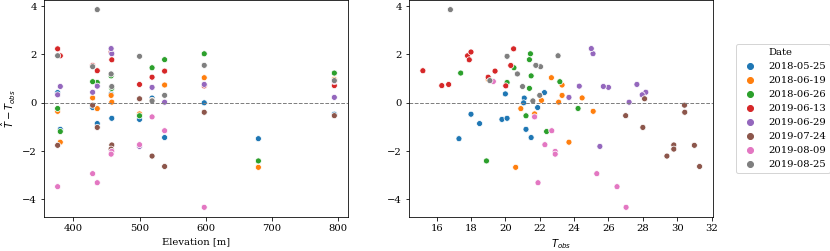

In [17]:
fig = utils.plot_err_elev_obs(comparison_df)
fig.savefig('../reports/figures/spatial-regression-errors.pdf')

### Plotting the maps predicted by the spatial regression

In [18]:
!make -C .. tair_regr_maps

make: Entering directory '/home/martibosch/data-science/lausanne-heat-islands'
make: Nothing to be done for 'tair_regr_maps'.
make: Leaving directory '/home/martibosch/data-science/lausanne-heat-islands'


In [19]:
tair_regr_filepath = '../data/processed/tair-regr-maps.nc'
station_locations_filepath = '../data/raw/stations/station-locations.csv'

In [20]:
T_regr_da = xr.open_dataarray(tair_regr_filepath)
station_location_df = pd.read_csv(station_locations_filepath, index_col='stn')

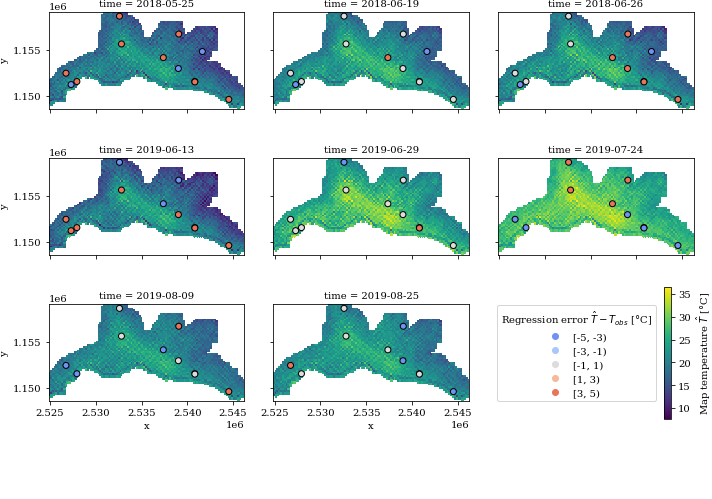

In [21]:
g = utils.plot_T_maps(T_regr_da,
                      station_location_df,
                      comparison_df=comparison_df)
g.fig.savefig('../reports/figures/spatial-regression-maps.png')